In [2]:
!python -V
import numpy as np
import seaborn as sns
import time
from typing import Callable

rng = np.random.default_rng(1234)

Python 3.13.3


# Question 1

## (a)

For a general Ito process $dX_t = a(t, X_t) dt + b(t, X_t) dW_t$, we recall that the Milstein scheme is given by

$$
\hat{X}_{n+1} = \hat{X}_n + a(t_n, \hat{X}_n) \Delta t + b(t_n, \hat{X}_n) \Delta W_{n+1} + b_x (t_n, \hat{X}_n) b(t_n, \hat{X}_n) \left( \frac{(\Delta W_{n+1})^2 - \Delta t}{2} \right)
$$
Where $\Delta W_{n} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \Delta t)$

Therefore, for $dV_t = \kappa (\theta - V_t) dt + \eta \sqrt{V_t} dW_t$ we have that its Milstein scheme is given by

$$
    \begin{align*}
        \hat{V}_{n+1} &= \hat{V}_n + \kappa (\theta - \hat{V}_n) \Delta t + \eta \sqrt{\hat{V}_n} \Delta W_{n+1} + \frac{\eta}{2 \sqrt{\hat{V}_n}} \cdot \eta \sqrt{\hat{V}_n} \left( \frac{(\Delta W_{n+1})^2 - \Delta t}{2} \right) \\
        &= \hat{V}_n + \kappa (\theta - \hat{V}_n) \Delta t + \eta \sqrt{\hat{V}_n} \Delta W_{n+1} + \frac{\eta^2}{4} \left( (\Delta W_{n+1})^2 - \Delta t \right)
    \end{align*} 
$$

## (b)

In [15]:
def euler_euler_path(
    *,
    dt: float,
    T: float,
    r: float,
    kappa: float,
    theta: float,
    eta: float,
    s0: float,
    v0: float,
    rho: float
) -> tuple[np.ndarray, np.ndarray]:
    '''
    Simulates one path by performing Euler-Mayurama for both St, Vt.
    Returns a tuple (St, Vt).

    Note that this assumes that `T = k * dt` for some integer `k`.
    Thus, this simulates `k` steps.
    '''
    total_runs = int(T / dt)
    s_path = np.empty(total_runs)
    v_path = np.empty(total_runs)
    s_path[0], v_path[0] = s0, v0

    sqrt_dt = np.sqrt(dt)
    # simulate each path (skip first step since that's done above)
    for i in range(1, total_runs):
        # first, correlate the brownian motions
        b1, b2 = rng.normal(loc=0, scale=sqrt_dt, size=2)
        w1, w2 = b1, rho * b1 + np.sqrt(1 - rho**2) * b2

        if v_path[i-1] < 0: # prevent errors from negative v_p.
            v_path[i-1] = 0
        # simulate s
        s_path[i] = s_path[i-1] + r * s_path[i-1] * dt + s_path[i-1] * np.sqrt(v_path[i-1]) * w1

        # simulate v (using euler)
        v_path[i] = v_path[i-1] + kappa * (theta - v_path[i-1]) * dt + eta * np.sqrt(v_path[i-1]) * w2

    return s_path, v_path


In [16]:
def euler_milstein_path(
    *,
    dt: float,
    T: float,
    r: float,
    kappa: float,
    theta: float,
    eta: float,
    s0: float,
    v0: float,
    rho: float
) -> tuple[np.ndarray, np.ndarray]:
    '''
    Simulates one path by performing Euler-Mayurama for St, Milstein for Vt.
    Returns a tuple (St, Vt).

    Note that this assumes that `T = k * dt` for some integer `k`.
    '''
    total_runs = int(T / dt)
    s_path = np.empty(total_runs)
    v_path = np.empty(total_runs)
    s_path[0], v_path[0] = s0, v0

    sqrt_dt = np.sqrt(dt)
    # simulate each path (skip first step since that's done above)
    for i in range(1, total_runs):
        # first, correlate the brownian motions
        b1, b2 = rng.normal(loc=0, scale=sqrt_dt, size=2)
        w1, w2 = b1, rho * b1 + np.sqrt(1 - rho**2) * b2

        if v_path[i-1] < 0: # prevent errors from negative v_p.
            v_path[i-1] = 0
        # simulate s
        s_path[i] = s_path[i-1] + r * s_path[i-1] * dt + s_path[i-1] * np.sqrt(v_path[i-1]) * w1

        # simulate v (using milstein)
        v_path[i] = v_path[i-1] + kappa * (theta - v_path[i-1]) * dt + eta * np.sqrt(v_path[i-1]) * w2 + (eta**2 / 4) * (w2**2 - dt)

    return s_path, v_path

In [17]:
def generate_mc_samples(
    M: int,
    method: Callable[..., tuple[np.ndarray, np.ndarray]],
    **kwargs
) -> np.ndarray:
    '''
    Generate `M` samples using `method`. 
    Returns a 2d array, where each row is a simulation of `St`.
    
    `kwargs` are passed into `method`. Note that `dt = 1 / path_size`.
    '''
    s_paths = np.array([method(**kwargs)[0] for _ in range(M)])
    
    return s_paths

In [18]:
# now compute desired statistics for each simulation

# parameters
M       = int(1e5)
K       = 100
Nt      = 52
T       = 1
r       = 0.05
kappa   = 1
theta   = 0.2
eta     = 0.5
rho     = -0.4
s0      = 100
v0      = 0.25

def print_summary_stats(
    paths: np.ndarray,
    exponent_term: int
):
    '''
    Given `paths`, print the summary statistics for each option
    '''
    # compute put option samples
    put_samples: np.ndarray = np.exp(-r * T) * (K - paths[:, -1])
    put_samples[put_samples < 0] = 0

    put_mean = put_samples.mean()
    put_width = put_samples.std(mean=put_mean) / np.sqrt(len(put_samples))
    print(
        f'\nPut Option: Simulation with r={exponent_term}',
        f'95% confidence interval: [{put_mean - 1.96 * put_width:.2f}, {put_mean + 1.96 * put_width:.2f}]',
        f'99% confidence interval: [{put_mean - 2.57 * put_width:.2f}, {put_mean + 2.57 * put_width:.2f}]',
        sep='\n'
    )

    # compute asian option samples
    asian_samples: np.ndarray = np.exp(-r * T) * (paths[:, -1] - paths[:, ::2**exponent_term].mean())
    asian_samples[asian_samples < 0] = 0

    asian_mean = asian_samples.mean()
    asian_width = asian_samples.std(mean=asian_mean) / np.sqrt(len(asian_samples))
    print(
        f'\nAsian Option: Simulation with r={exponent_term}',
        f'95% confidence interval: [{asian_mean - 1.96 * asian_width:.2f}, {asian_mean + 1.96 * asian_width:.2f}]',
        f'99% confidence interval: [{asian_mean - 2.57 * asian_width:.2f}, {asian_mean + 2.57 * asian_width:.2f}]',
        sep='\n'
    )

for exponent_term in range(1, 5):
    # start with euler-euler simulations
    print(f'Euler-Euler scheme with r = {exponent_term}\n')
    ee_start_time = time.time()
    ee_s_paths = generate_mc_samples(
        M=M, 
        method=euler_euler_path,
        dt=1 / (52 * 2 ** exponent_term),
        T=1,
        r=r,
        kappa=kappa,
        theta=theta,
        eta=eta,
        rho=rho,
        s0=s0,
        v0=v0
    )
    ee_end_time = time.time()
    print(f'Time elapsed: {ee_end_time - ee_start_time:.2f} seconds')
    print_summary_stats(
        ee_s_paths,
        exponent_term=exponent_term
    )


    print(f'\nEuler-Milstein scheme with r={exponent_term}')
    em_start_time = time.time()
    em_s_paths = generate_mc_samples(
        M=M, 
        method=euler_milstein_path,
        dt=1 / (52 * 2 ** exponent_term),
        T=1,
        r=r,
        kappa=kappa,
        theta=theta,
        eta=eta,
        rho=rho,
        s0=s0,
        v0=v0
    )
    em_end_time = time.time()
    print(f'Time elapsed: {em_end_time - em_start_time:.2f} seconds')
    print_summary_stats(
        em_s_paths,
        exponent_term=exponent_term
    )
    print('-----------------------------------')

    # compute euler-euler put option samples

Euler-Euler scheme with r = 1

Time elapsed: 91.17 seconds

Put Option: Simulation with r=1
95% confidence interval: [15.41, 15.67]
99% confidence interval: [15.37, 15.71]

Asian Option: Simulation with r=1
95% confidence interval: [19.15, 19.57]
99% confidence interval: [19.09, 19.64]

Euler-Milstein scheme with r=1
Time elapsed: 125.78 seconds

Put Option: Simulation with r=1
95% confidence interval: [15.39, 15.64]
99% confidence interval: [15.35, 15.68]

Asian Option: Simulation with r=1
95% confidence interval: [19.01, 19.43]
99% confidence interval: [18.95, 19.49]
-----------------------------------
Euler-Euler scheme with r = 2

Time elapsed: 237.45 seconds

Put Option: Simulation with r=2
95% confidence interval: [15.37, 15.63]
99% confidence interval: [15.33, 15.67]

Asian Option: Simulation with r=2
95% confidence interval: [18.95, 19.36]
99% confidence interval: [18.88, 19.43]

Euler-Milstein scheme with r=2
Time elapsed: 254.67 seconds

Put Option: Simulation with r=2
95% co

## (c)

The first observation to make is that the Euler-Euler (EE) and Euler-Milstein (EM) schemes take roughly the same amount of time to compute sample paths. While EE is faster for small $r$, this gap closes as $r$ increases.

Secondly, as $\Delta t \to 0$ the convergence is very slow. The accuracy for the Put option of EE improves to 5 cents then stays roughly constant. For the Asian option EE, the range stays roughly at 40 cents each iteration.

For EM, the convergence is also slow. The Asian 95 interval width is 42 cents for $r=1$, improving to 41 cents for $r=4$.

Lastly, as for how the two methods compare to each other, they perform roughly the same each iteration, where the width of the 95 intervals don't change by very much.


# Question 2

## (a)

In [48]:
# set parameters
T = 2
r = 0.05
mu = 0.25
sig = 0.25
lam = 6
zeta = 50
gamma = -1.5
dt = 0.02

rng = np.random.default_rng(1234)

To make things simpler, first we simulate the dynamics of $S_t$, then use this path to compute a path for $X_t$. We have that

$$
    dS_t = \mu S_t dt + \sigma S_t dW_t - S_{t-} dJ_t
$$
Where $J_t = \sum_{i=1}^{N_t} e^{Y_j} - 1$, $N_t \sim \mathrm{Pois}(\lambda t)$, $Y_j \overset{\mathrm{iid}}{\sim} \mathrm{Exp}(\zeta)$. To accomplish this, we use the following scheme

$$
\begin{align*}
    \hat{S}_{n+1} &= \hat{S}_n + \mu \hat{S}_n \Delta t + \sigma \hat{S}_n \Delta W_{n+1} \\
    \hat{S}_{n+1} &:= \hat{S}_{n+1} - \hat{S}_{n+1} \cdot \left( e^{Y_n} - 1 \right) \Delta N_{n+1} 
\end{align*}
$$
Where the 2nd equal sign is interpreted as a reassignment and $\Delta N_n \overset{\mathrm{iid}}{\sim} \mathrm{Bernoulli}(\lambda \Delta t)$.

In [49]:
# first simulate S_t
def simulate_s(s0: float=100) -> np.ndarray:
    '''
    Returns a sample path of S_t
    '''
    points = int(T / dt)
    s_path = np.empty(points)
    s_path[0] = s0

    for i in range(1, points):
        s_path[i] = s_path[i-1] + mu * s_path[i-1] * dt + sig * s_path[i-1] * rng.normal(scale=np.sqrt(dt))
        if rng.random() < lam * dt: # if a jump occured
            s_path[i] *= (2 - np.exp(rng.exponential(1/zeta)))
        
        if s_path[i] < 0:
            s_path[i] = 0

    return s_path

To simulate $X_t$, we approximate $dX_t = \pi X_t \frac{dS}{S_t} + (1 - \pi) X_t \frac{dB_t}{B_t}$ using the scheme

$$
    \hat{X}_{n+1} = \hat{X}_n + \pi \hat{X}_n \frac{\Delta \hat{S}_{n+1}}{\hat{S}_n} + (1 - \pi) \hat{X}_n r \Delta t
$$
Where $\Delta \hat{S}_{n} = \hat{S}_{n} - \hat{S}_{n-1}$

In [50]:
def simulate_x(pi: float = 0.5, x0 = 50, s_path: np.ndarray = None) -> np.ndarray:
    '''
    Return a sample path of S_t. s_path is a given path of samples (a new path will be simulated if this isn't passed)
    '''
    s_path = s_path if s_path is not None else simulate_s()
    dS = np.diff(s_path) # note that this has 1 less size, e.g. len(dS) = len(s_path) - 1
    x_path = np.empty(len(s_path))
    x_path[0] = x0

    for i in range(1, len(s_path)):
        x_path[i] = x_path[i-1] + pi * x_path[i-1] * dS[i-1] / s_path[i-1] + (1 - pi) * x_path[i-1] * dt
    
    return x_path

In [51]:
def compute_utility_samples(
    pi: float = 0.5,
    x0 = 50, 
    s_path: np.ndarray | None = None,
    sims = 10000
) -> np.ndarray:
    x_samples = np.array([simulate_x(pi, x0=x0, s_path=s_path) for _ in range(sims)])
    utility_samples = x_samples[:, -1]**gamma / gamma

    return utility_samples

samps = compute_utility_samples()
samps_avg = samps.mean()
samps_std = samps.std(mean=samps_avg)
print(
    f'MC Average with Pi = 0.5, X0 = 50, S0 = 100: {samps_avg:.6f}',
    f'95 Confidence Interval: [{samps_avg - 1.96 * samps_std / np.sqrt(len(samps)):.6f}, {samps_avg + 1.96 * samps_std / np.sqrt(len(samps)):.6f}]',
    sep='\n'
)

MC Average with Pi = 0.5, X0 = 50, S0 = 100: -0.000379
95 Confidence Interval: [-0.000381, -0.000377]


## (b)

<Axes: >

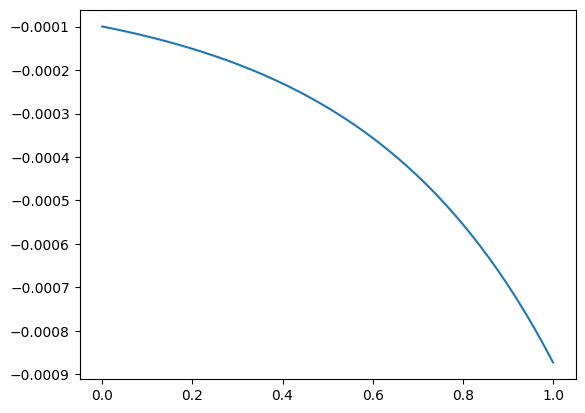

In [52]:
pis = np.linspace(start=0, stop=1, num=51) # 0, 0.02, 0.04, ...

s_samples = simulate_s()

results = [compute_utility_samples(pi=pi, sims=1000, s_path=s_samples).mean() for pi in pis]

sns.lineplot(x=pis, y=results)